# Model Training and Evaluation

In [262]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import iqr
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_validate


import pickle
import os


## Base Models

The first set of models to be implemented will be based on the simplest preprocessing method, without any feature engineering. These models will act as a benchmark for all subsequent attempts. The set will include a K-Neighbors Classifier, Decision Tree, Gradient Boosting, Random Forest, Linear Discriminant Analysis and Logistic Regression model. The models will be compared between eachother and a feature improtance plot will be plotted using the best-performing model. 

The data is split using scikit-learn's `train_test_split()` method, in order to minimise bias in score evaluation. 

K-Fold cross validation (with 10 splits) is used to avoid overfitting. K=10 was chosen as it is a generally acceptable number for this method.

The plot clearly shows that the random forrest model outperforms all other models. It is followed by the gradient boosting model, the decision tree and KNN. Linear Discriminant Ananlysis and the Logistic Regression are the worst performing models. The exact test score for each model are presented below.

The random forrest algorithm was used to extract feature importance for the data set. Thsi plot depicts the variables which according to the model are most important in determining the level of passenger satisfaction. It can be seen that `Online Boarding`, `Inflight Wifi Service` and `Class` are the top three features. 

### Base Model with Iterative Imputer

In [315]:
train_imputed_iterative = pd.read_pickle('../Data/Preprocessed/train_imputed_iterative.pkl')

In [316]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [340]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')


                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943275
                             Precision  0.951293
                             Recall     0.948455
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.962860
                             Precision  0.955403
                             Recall     0.980194


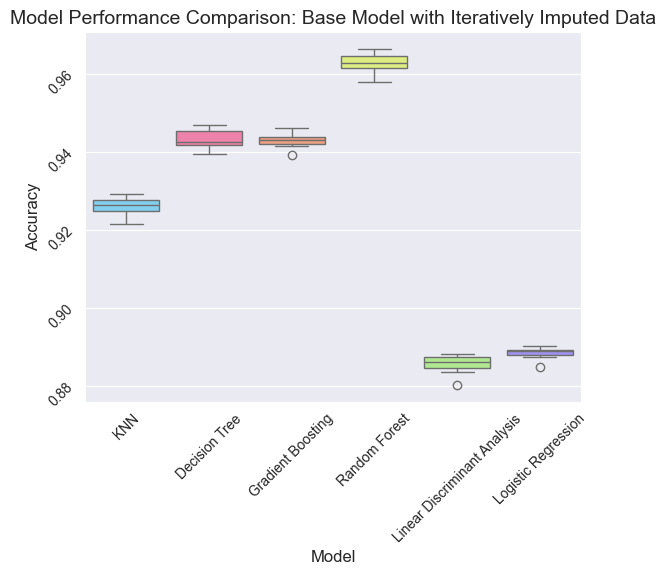

In [342]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with Iteratively Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

### Base Model with KNN Imputer 

In [343]:
train_imputed_knn = pd.read_pickle('../Data/Preprocessed/train_imputed_knn.pkl')

In [344]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [345]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943101
                             Precision  0.951318
                             Recall     0.948095
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.962966
                             Precision  0.955518
                             Recall     0.980256


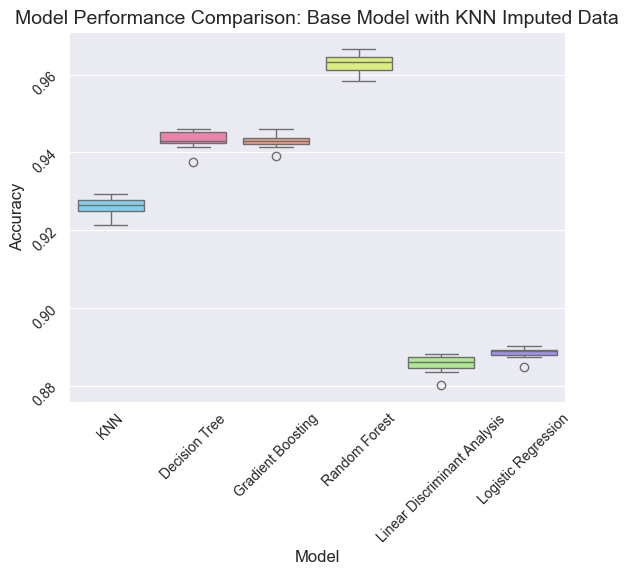

In [346]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with KNN Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

### Base Model with DropNa and Mode Imputation

In [347]:
# Importing the preprocessed data:
train = pd.read_pickle('../Data/Preprocessed/train_preprocessed_dropna_mode.pkl')

In [348]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [349]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943246
                             Precision  0.951545
                             Recall     0.948114
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.963062
                             Precision  0.955948
                             Recall     0.979950


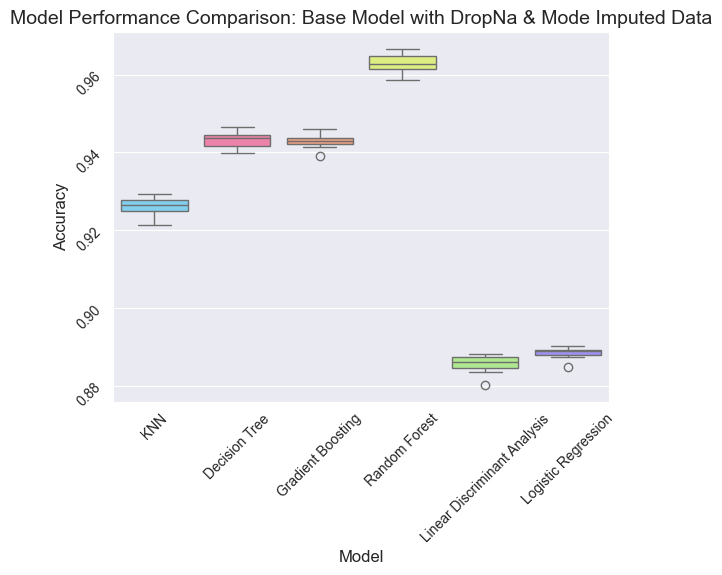

In [350]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

### Base Model with Non-Applicable Category

In [364]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

In [365]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [366]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943063
                             Precision  0.951120
                             Recall     0.948254
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.963187
                             Precision  0.956199
                             Recall     0.979901


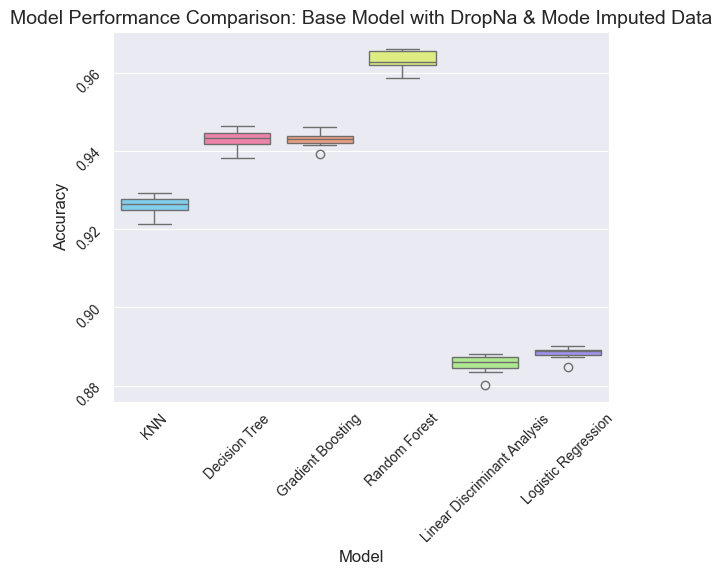

In [367]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

## Feature Selection Model

In this section, the intial models will remain the same but the data preprocessing will be changed. The model will be implemented with data where only features correlated with the response variable were selected. Otherwise, the same process is implemented as that in the previous model.

In [150]:
# Importing the preprocessed data:
train_fs = pd.read_pickle('../Data/Feature_Selection/train_fs.pkl')

In [151]:
# Splitting the data into train and test sets:
X = train_fs.drop(columns = 'Satisfaction', axis = 1)
y = train_fs['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [157]:
# Defining and implementing the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Kfold cross-validation is used to ensure reproducibility of results:
# results = []

# for name, model in models.items():
    # kf = KFold(n_splits=6, random_state=42, shuffle=True)
    # cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    # for result in cv_results:
       # results.append([name, result])

# Convert results into a DataFrame:
# kf_cv_data = pd.DataFrame(results, columns=['Model', 'Metric'])

# Saving results:
# kf_cv_data.to_pickle('../Models/Model_2/kf_cv_data.pkl')

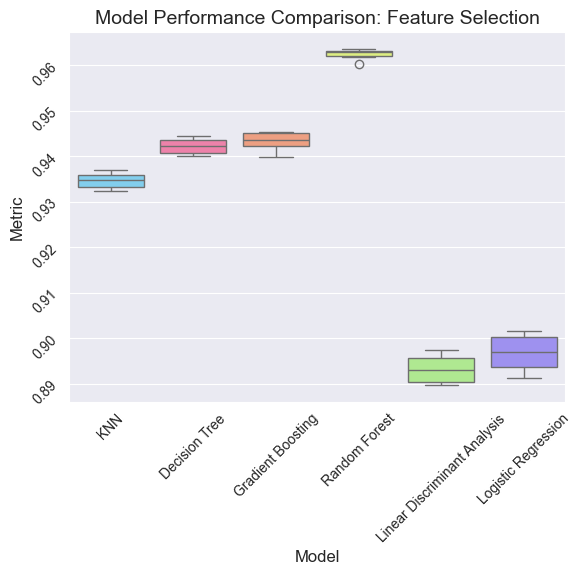

In [159]:
# Loading the results:
kf_cv_data = pd.read_pickle('../Models/Model_2/kf_cv_data.pkl')

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=bm_data, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Selection', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Metric', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Again, it can be seen that the random forrest algorithm outperforms the other models. It is not clear from the plot, however, if this configuration performs better than the base models.

In [158]:
# Renaming models to be saved
models = {'knn': KNeighborsClassifier(),
          'decision_tree': DecisionTreeClassifier(),
          'gradient_boosting': GradientBoostingClassifier(),
          'random_forest': RandomForestClassifier(),
          'linear_discriminant_analysis': LinearDiscriminantAnalysis(),
          'logistic_regression': LogisticRegression()}

# for name, model in models.items():
     # model.fit(X_train_scaled, y_train)
     # test_score = model.score(X_test_scaled, y_test)
     # print('{} test set accuracy: {}'.format(name, test_score))
     # save each model as a pickle file
     # model_pkl_file = '../Models/Model_2/{}.pkl'.format(name)  
     # with open(model_pkl_file, 'wb') as file:  
         # pickle.dump(model, file)

knn test set accuracy: 0.9357340346618113
decision_tree test set accuracy: 0.9418369411288691
gradient_boosting test set accuracy: 0.943320520601524
random_forest test set accuracy: 0.9613932159956842
linear_discriminant_analysis test set accuracy: 0.894733292872075
logistic_regression test set accuracy: 0.8980713466855486


The exact accuracy scores (on the test set) show that the random forrest performed slightly worse than the base model. This seems to be the case for most of the other models as well. 

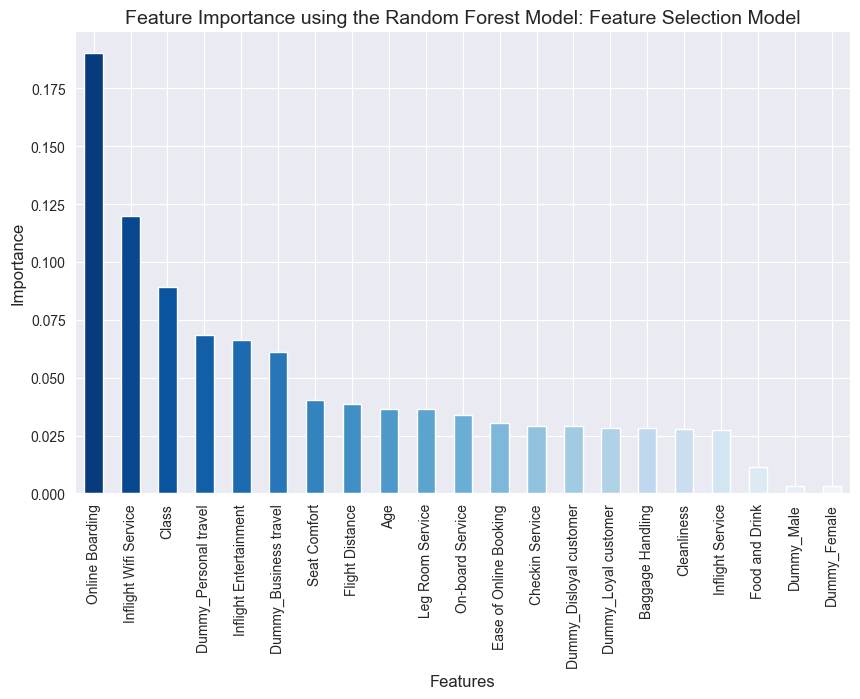

In [160]:
# Dictionary to store loaded models:
loaded_models = {}

# Loading the saved models:
for name in models.keys():
    model_pkl_file = '../Models/Model_2/{}.pkl'.format(name)
    with open(model_pkl_file, 'rb') as file: 
        loaded_models[name] = pickle.load(file) 

# Plotting feature importance using random_forest:
if 'random_forest' in loaded_models:
    model_rf = loaded_models['random_forest']
    importance = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    colors = list(reversed(sns.color_palette("Blues", len(importance))))
    ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
    # Customising the plot:
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance', fontsize=12)
    ax.set_title('Feature Importance using the Random Forest Model: Feature Selection Model', fontsize=14)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()
else:
    print("Random Forest model is not loaded.")

The same variables have been chosen as most important by the random forrest algorithm in this case also.

# Feature Extraction Model

The same models will be tested with two extra aggregated features, `Overall Satisfaction Score` and `Premium Service`. 

In [161]:
# Importing the preprocessed data:
train_oss = pd.read_pickle('../Data/Feature_Extraction/train_oss.pkl')

In [162]:
# Splitting the data into train and test sets:
X = train_oss.drop(columns = 'Satisfaction', axis = 1)
y = train_oss['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [163]:
# Defining and implementing the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Kfold cross-validation is used to ensure reproducibility of results:
# results = []

# for name, model in models.items():
    # kf = KFold(n_splits=6, random_state=42, shuffle=True)
    # cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    # for result in cv_results:
       # results.append([name, result])

# Convert results into a DataFrame:
# kf_cv_data = pd.DataFrame(results, columns=['Model', 'Metric'])

# Saving results:
# kf_cv_data.to_pickle('../Models/Model_3/kf_cv_data.pkl')

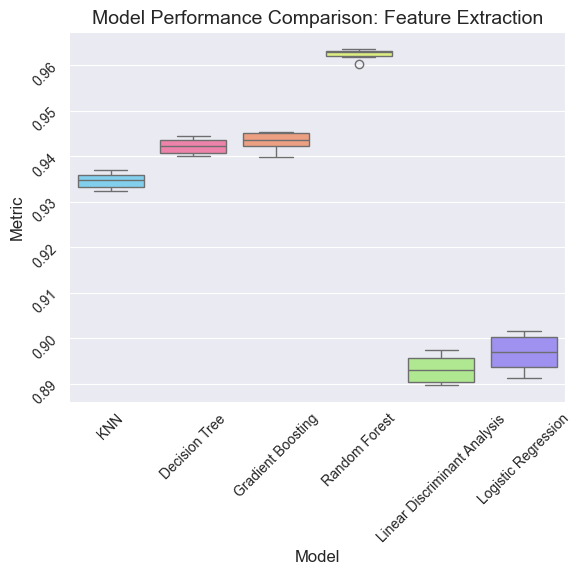

In [164]:
# Loading the results:
kf_cv_data = pd.read_pickle('../Models/Model_3/kf_cv_data.pkl')

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=bm_data, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Extraction', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Metric', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

The model comparison plot looks almost identical to the previous two. 

In [166]:
# Renaming models to be saved
models = {'knn': KNeighborsClassifier(),
          'decision_tree': DecisionTreeClassifier(),
          'gradient_boosting': GradientBoostingClassifier(),
          'random_forest': RandomForestClassifier(),
          'linear_discriminant_analysis': LinearDiscriminantAnalysis(),
          'logistic_regression': LogisticRegression()}

# for name, model in models.items():
     # model.fit(X_train_scaled, y_train)
     # test_score = model.score(X_test_scaled, y_test)
     # print('{} test set accuracy: {}'.format(name, test_score))
     # save each model as a pickle file
     # model_pkl_file = '../Models/Model_3/{}.pkl'.format(name)  
     # with open(model_pkl_file, 'wb') as file:  
         # pickle.dump(model, file)

knn test set accuracy: 0.9370827432733158
decision_tree test set accuracy: 0.9420392474205947
gradient_boosting test set accuracy: 0.9459167846786701
random_forest test set accuracy: 0.9627419246071887
linear_discriminant_analysis test set accuracy: 0.8973295569492211
logistic_regression test set accuracy: 0.9027243913952391


It can be seen that this combination has not been able to outperform the base models either.

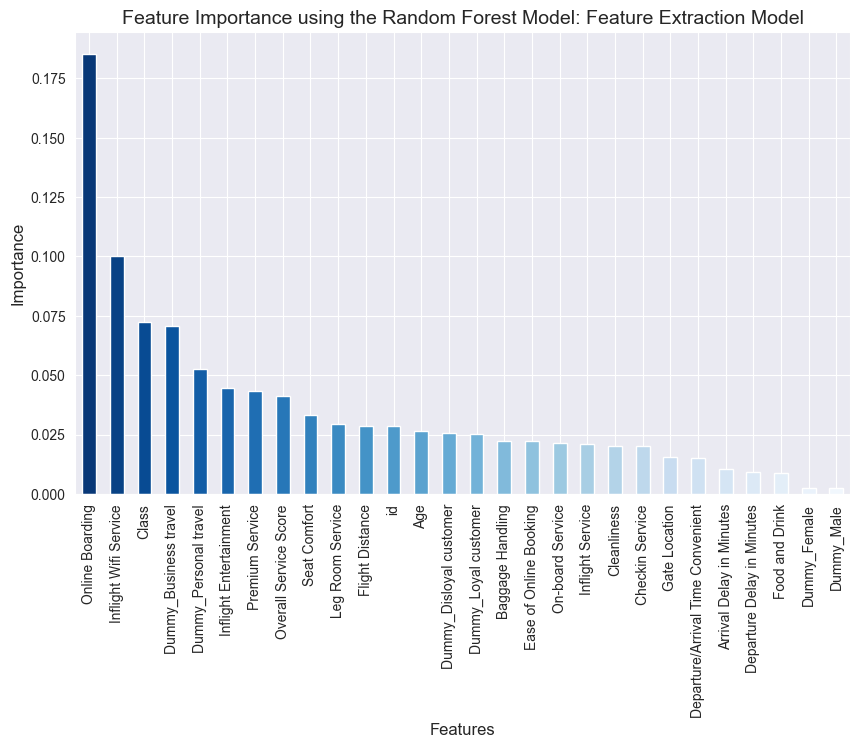

In [167]:
# Dictionary to store loaded models:
loaded_models = {}

# Loading the saved models:
for name in models.keys():
    model_pkl_file = '../Models/Model_3/{}.pkl'.format(name)
    with open(model_pkl_file, 'rb') as file: 
        loaded_models[name] = pickle.load(file) 

# Plotting feature importance using random_forest:
if 'random_forest' in loaded_models:
    model_rf = loaded_models['random_forest']
    importance = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    colors = list(reversed(sns.color_palette("Blues", len(importance))))
    ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
    # Customising the plot:
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance', fontsize=12)
    ax.set_title('Feature Importance using the Random Forest Model: Feature Extraction Model', fontsize=14)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()
else:
    print("Random Forest model is not loaded.")

The top 3 most important features have so far remained the same. 